In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score

C:\Users\TULASI RAM\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#sqlite3 method seems more appropriate to work with this data
#importing sqlite3
import sqlite3
#creating connection with the DataBase file.
#Here in final.sqlite  already preprocessed data is added in one column named Cleaned Text
con=sqlite3.connect('H:\\AI\\amazon_food_reviews\\final.sqlite')
final_data=pd.read_sql_query("""SELECT * FROM Reviews """, con)
#it is always required to close the connection
con.close()

In [3]:
print(final_data.columns)
print(final_data.shape)

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText', 'WordCount'],
      dtype='object')
(364171, 13)


In [4]:
final_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...,35
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...,27
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...,15
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...,50
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...,37


In [5]:
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [6]:
#Selecting the sample of the dataframe for the operations


Negative = final_data.loc[final_data['Score'] == 'negative']
Positive = final_data.loc[final_data['Score'] == 'positive']

print(Negative.shape)
print(Positive.shape)

(57110, 13)
(307061, 13)


In [7]:
#As the data looks to be imbalanced we are sampling the data and making it balanced
np.random.seed(100)
indices=np.random.randint(0, 57110, size=57110)
Negative = Negative.iloc[indices]
print('Negative reviews shape', Negative.shape)
indices=np.random.randint(0, 307061, size=200000)
Positive = Positive.iloc[indices]
print('Positive reviews shape', Positive.shape)
sampled_data=pd.concat([Negative,Positive],ignore_index=False)
print('Sampled data shape', sampled_data.shape)

Negative reviews shape (57110, 13)
Positive reviews shape (200000, 13)
Sampled data shape (257110, 13)


In [8]:
sampled_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
252992,242289,262770,B002V0XB62,A12ENXDRY04XYZ,Josh,0,0,negative,1320019200,"Okay overall, very strong non-bacon flavor.",I received a box of this as a gift from my gir...,b'receiv box gift girlfriend almost immedi tri...,48
358004,311514,337271,B007OSBE1U,#oc-R12KPBODL2B5ZD,Christopher P. Presta,5,8,negative,1348617600,Not what I expected,I didnt like this coffee. Instead of telling y...,b'didnt like coffe instead tell didnt like tel...,26
95734,240539,260908,B000LKTBMM,AMVB0GDUXWM2R,jackie,1,1,negative,1307232000,worst gf baking mix EVER,this may have been one of the earliest mixes b...,b'may one earliest mix food come long way eat ...,67
83393,117269,127167,B000HDL1P8,A2YI093RCI57PI,rosekelly,1,2,negative,1234396800,Wimpy and definitely NOT restaurant quality.,I bought this soup based on the glorious revie...,b'bought soup base glorious review armageddon ...,87
544,192826,209072,B00004RAMY,ADBZZKMY9DZ11,Darrell W Nope,0,1,negative,1314576000,Dissatisfied,The trap is difficult to set. It requires a l...,b'trap difficult set requir lot physic exert a...,18


In [9]:
sorted_data=sampled_data.sort_values(by=['Time'])

sorted_data.head()


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,WordCount
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...,30
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...,26
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...,26
308,346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...,32
261,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,b'happen say name three time michael keaten st...,104


In [10]:
from sklearn import cross_validation
labels=sorted_data['Score']
#Splitting the data into train and test 
X_1, X_test, Y_1, Y_test=cross_validation.train_test_split(sorted_data['CleanedText'] , labels, test_size=0.25 ,random_state=0)


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(binary=True)
bow_vect = bow_vectorizer.fit_transform(X_1)

In [13]:
print(bow_vect.shape)

(192832, 46250)



The optimal alpha value is 1.


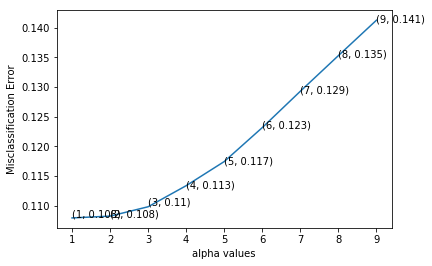

the misclassification error for each alpha value is :  [0.108 0.108 0.11  0.113 0.117 0.123 0.129 0.135 0.141]


In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score

List = list(range(1,10))
cv_scores=[]
for k in List:
    NB = MultinomialNB(alpha=k)
    scores = cross_val_score(NB, bow_vect, Y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = List[MSE.index(min(MSE))]
print('\nThe optimal alpha value is %d.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(List, MSE)

for xy in zip(List, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('alpha values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))    


In [15]:
bow_vect_test = bow_vectorizer.transform(X_test)
print(bow_vect_test.shape)

(64278, 46250)


In [34]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
                   
    B =(C/C.sum(axis=0))
 
    labels = [1,2]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

-------------------- Confusion matrix --------------------


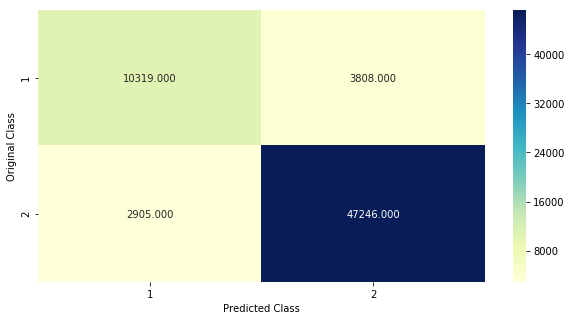

-------------------- Precision matrix (Columm Sum=1) --------------------


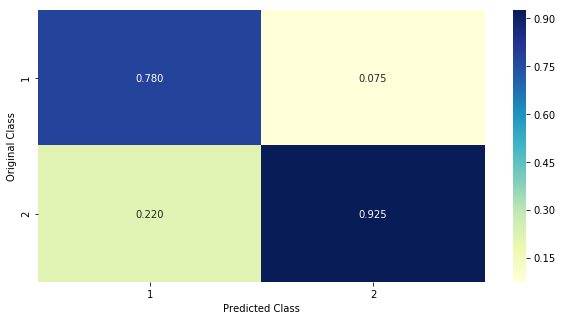

In [35]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


nb_optimal = MultinomialNB(alpha=optimal_alpha)

# fitting the model
nb_optimal.fit(bow_vect, Y_1)

# predict the response
pred = nb_optimal.predict(bow_vect_test)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
plot_confusion_matrix(Y_test,pred)

**CONCLUSION**

*Of all the points to be predicted as class1 , 78percent are actually class1, and 22 percent are actually class2.*

*Similarly,of all the points to be predicted as class2, 92.5 percent are actually class2 and 7.5 percent are actually class1.*

**TF-IDF**

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vect = tfidf_vectorizer.fit_transform(X_1)
tfidf_vect.shape

(192832, 46250)


The optimal alpha value is 1.


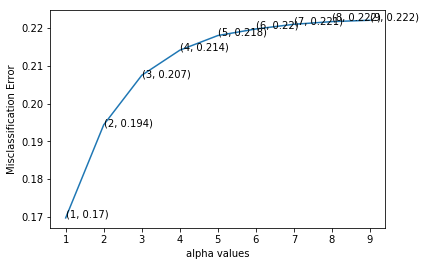

the misclassification error for each alpha value is :  [0.17  0.194 0.207 0.214 0.218 0.22  0.221 0.222 0.222]


In [24]:
List = list(range(1,10))
cv_scores=[]
for k in List:
    NB = MultinomialNB(alpha=k)
    scores = cross_val_score(NB, tfidf_vect, Y_1, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_alpha = List[MSE.index(min(MSE))]
print('\nThe optimal alpha value is %d.' % optimal_alpha)

# plot misclassification error vs k 
plt.plot(List, MSE)

for xy in zip(List, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('alpha values')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each alpha value is : ", np.round(MSE,3))    


In [26]:
tfidf_vect_test = tfidf_vectorizer.transform(X_test)
print(tfidf_vect_test.shape)

(64278, 46250)


-------------------- Confusion matrix --------------------


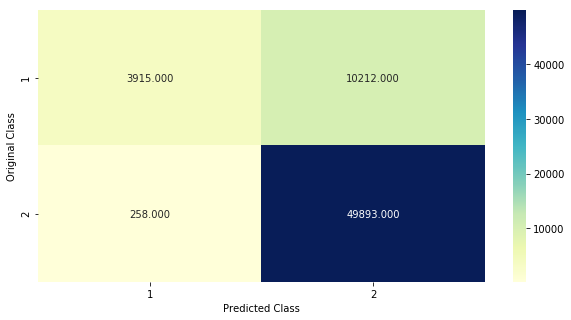

-------------------- Precision matrix (Columm Sum=1) --------------------


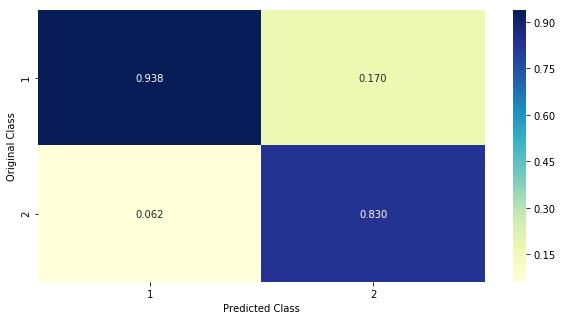

In [36]:
nb_optimal = MultinomialNB(alpha=optimal_alpha)

# fitting the model
nb_optimal.fit(tfidf_vect, Y_1)

# predict the response
pred = nb_optimal.predict(tfidf_vect_test)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
plot_confusion_matrix(Y_test,pred)

**CONCLUSION**

*Of all the points to be predicted as class1, 93.8 percent are actually class1 and 6.2percent are actually class2.*

*Of all the points to be predicted as class2, 83.0 percent are actually class2 and 17percent are actually class1.*

**FINAL OBSEVARTION**

*BOW vectorization is most accuractely predicting class2 data points,while the TF-IDF vectorization is most accurately predicting class1 data points.*